In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

## Evaluation of musicality, coherence

In [13]:
df = pd.read_csv("rating_0430.csv", header=None)
df.loc[:, 2] = [0 for _ in range(len(df))]
df.loc[:, 3] = [0 for _ in range(len(df))]

for i, row in df.iterrows():
    val = [int(j) for j in row[1].split(', ')]
    df.loc[i, 2] = val[0]
    df.loc[i, 3] = val[1]

df.loc[:, 1] = [i.split('/')[0].split('-')[1] for i in df[0]]
df.loc[:, 0] = [i.split('/')[-1].split('.')[0] for i in df[0]]

last_id = ''
entry = {}
res = []
for _, row in df.iterrows():
    if row[0] != last_id:
        last_id = row[0]
        if len(entry) > 1:
            res.append(entry)
        entry = {'id': row[0]}
    entry[row[1]] = [row[2], row[3]]
res.append(entry)

In [3]:
valid_rating = [i for i in res if i['Anchor'][0] >= 3 and i['Anchor'][1] >= 3]
valid_idx = [i for i, v in enumerate(res) if v['Anchor'][0] >= 3 and v['Anchor'][1] >= 3]

anchor = np.array([i['Anchor'] for i in valid_rating])
proposed = np.array([i['Proposed'] for i in valid_rating])
baseline = np.array([i['Baseline'] for i in valid_rating])

/var/folders/_9/1b7m790508dgvpqd1wrb97f00000gn/T/ipykernel_35050/129943525.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(6), fontsize=14)


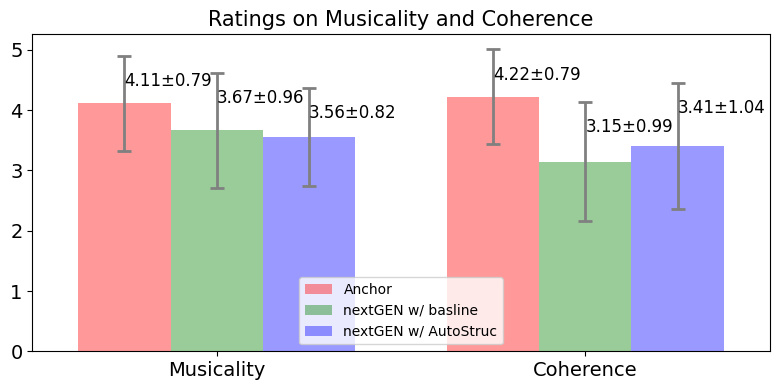

In [4]:
# Group and attribute labels
group_labels = ['Musicality', 'Coherence']
attribute_labels = ['Anchor', 'nextGEN w/ basline', 'nextGEN w/ AutoStruc']
colors = ['red', 'green', 'blue']  # use the first 3 colors

means = np.stack([np.mean(anchor, axis=0), np.mean(baseline, axis=0), np.mean(proposed, axis=0)]).T
stds = np.stack([np.std(anchor, axis=0), np.std(proposed, axis=0), np.std(baseline, axis=0)]).T

# Bar settings
n_groups = len(group_labels)
n_attrs = len(attribute_labels)
bar_width = 0.25
x = np.arange(n_groups)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(n_attrs):
    offset = (i - 1) * bar_width  # positions: -bar_width, 0, +bar_width
    ax.bar(x + offset, means[:,i], bar_width, yerr=stds[:,i], 
           capsize=5, label=attribute_labels[i], color=colors[i], alpha=0.4,
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

for i in range(3):
    plt.text(bar_width * (i-1), means[0,i]+stds[0,i]-0.5, f"{means[0, i]:.2f}\u00B1{stds[0, i]:.2f}", fontsize=12)
    
for i in range(3):
    plt.text(1 + bar_width * (i-1), means[1,i]+stds[1,i]-0.5, f"{means[1, i]:.2f}\u00B1{stds[1, i]:.2f}", fontsize=12)

# Styling
ax.set_title('Ratings on Musicality and Coherence', fontsize=15)
# ax.set_ylim(1, 5)
ax.set_xticks(x)
ax.set_xlim(-0.5, 1.5)
ax.set_xticklabels(group_labels, fontsize=14)
ax.set_yticklabels(np.arange(6), fontsize=14)
ax.legend(loc='lower center')

plt.tight_layout()
plt.savefig('Ratings', bbox_inches='tight', dpi=300)
plt.show()

## Evaluation of Structural Perception Agreement

In [5]:
from sklearn.cluster import DBSCAN
import numpy as np

def conv_str_to_int(arr_str):
    arr = arr_str.split(', ')
    arr = np.array([float(i)/1000 for i in arr])
    if arr[0] < 5:
        arr -= arr[0]
        arr = arr[1:]
    return arr

def segment_agreement(sequences, tol=1):
    all_ts = []
    source_ids = []
    for idx, seq in enumerate(sequences):
        all_ts.extend(seq)
        source_ids.extend([idx] * len(seq))
    
    X = np.array(all_ts).reshape(-1, 1)
    clustering = DBSCAN(eps=tol, min_samples=1).fit(X)
    
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters == 0:
        return 0.0
    
    # Count how many unique sources per cluster
    cluster_sources = {}
    for label, src_id in zip(labels, source_ids):
        if label == -1:
            continue
        cluster_sources.setdefault(label, set()).add(src_id)
    
    avg_coverage = np.mean([len(sources) for sources in cluster_sources.values()])
    normalized_coverage = avg_coverage / len(sequences)  # between 0 and 1

    return normalized_coverage

In [15]:
# df = pd.read_csv("struct_bound_0418.csv", header=None)
df = pd.read_csv("struct_bound_0430.csv", header=None)
idx = []
for i in valid_idx:
    tmp = i * 3
    idx += [tmp, tmp+1, tmp+2]
df = df.loc[idx]
df.reset_index(inplace=True, drop=True)

In [24]:
res = []
valid_sample = ['02', '09', '10']  # The only 3 groups of outputs that have sufficient annotations
for k, idx in enumerate(valid_sample):
    sample_res = []
    for model in ['Anchor', 'Baseline', 'Proposed']:
        fname = f"{model}/{idx}"
        data = [conv_str_to_int(df.loc[i, 1]) for i, v in enumerate(df[0]) if fname in v]
        sample_res += [segment_agreement(data, tol=1)]
    res += [sample_res]

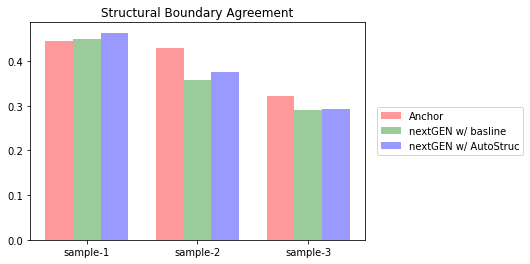

In [69]:
# Group and attribute labels
group_labels = ['sample-1', 'sample-2', 'sample-3']
attribute_labels = ['Anchor', 'nextGEN w/ basline', 'nextGEN w/ AutoStruc']
colors = ['red', 'green', 'blue']  # use the first 3 colors

# Means and standard deviations
means = np.array(res)

# Bar settings
n_groups = len(group_labels)
n_attrs = len(attribute_labels)
bar_width = 0.25
x = np.arange(n_groups)

# Plot
fig, ax = plt.subplots()

for i in range(n_attrs):
    offset = (i - 1) * bar_width  # positions: -bar_width, 0, +bar_width
    ax.bar(x + offset, means[:,i], bar_width, 
           capsize=5, label=attribute_labels[i], color=colors[i], alpha=0.4)

# Styling
ax.set_title('Structural Boundary Agreement')
ax.set_xticks(x)
ax.set_xticklabels(group_labels)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

# plt.tight_layout()
plt.savefig('bound', bbox_inches='tight', dpi=300)
plt.show()